In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
import random
from makemore import (
    PytorchifiedBatchNorm,
    Sequential,
    Embedding,
    Flatten,
    Linear,
    Tanh,
    BatchNorm1d,
    load_words,
)

%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
train_words, dev_words, test_words = load_words()

In [9]:
pytorchified = PytorchifiedBatchNorm(
    sizes=[68, 68, 68],
    batchnorm_output=False,
    block_size=block_size,
    flatten_consecutive=True,
)
model = Sequential(pytorchified.layers)

In [11]:
lossi, ud = pytorchified.train(train_words)

Epoch 0 Loss: 2.3193119174661416
Epoch 1 Loss: 2.1993339342660163
Epoch 2 Loss: 2.1611921022724405
Epoch 3 Loss: 2.1376125380582485
Epoch 4 Loss: 2.1196265277537907
Epoch 5 Loss: 2.106169133316866
Epoch 6 Loss: 2.0946456141839174
Epoch 7 Loss: 2.0847935071638286
Epoch 8 Loss: 2.077530547639198
Epoch 9 Loss: 2.0701855431106724
Epoch 10 Loss: 2.064427415055755
Epoch 11 Loss: 2.058994160846443
Epoch 12 Loss: 2.0530269218340402
Epoch 13 Loss: 2.0480684442966943
Epoch 14 Loss: 2.0446496058355446
Epoch 15 Loss: 2.039637278770016
Epoch 16 Loss: 2.0375574531628806
Epoch 17 Loss: 2.0334267123244607
Epoch 18 Loss: 2.0321617572009303
Epoch 19 Loss: 2.027456595387704
Epoch 20 Loss: 2.0252285187736816
Learning rate reduced to 0.01
Epoch 21 Loss: 1.9771460622711168
Epoch 22 Loss: 1.9685672857527525
Epoch 23 Loss: 1.9668832037988138
Epoch 24 Loss: 1.9668581102956573
Epoch 25 Loss: 1.9641135364148592
Epoch 26 Loss: 1.963962703300037
Epoch 27 Loss: 1.9640535976117401
Epoch 28 Loss: 1.9624571862566322
E

In [12]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (21, 8, 10)
FlattenConsecutive : (21, 4, 20)
Linear : (21, 4, 68)
BatchNorm1d : (21, 4, 68)
Tanh : (21, 4, 68)
FlattenConsecutive : (21, 2, 136)
Linear : (21, 2, 68)
BatchNorm1d : (21, 2, 68)
Tanh : (21, 2, 68)
FlattenConsecutive : (21, 136)
Linear : (21, 68)
BatchNorm1d : (21, 68)
Tanh : (21, 68)
Linear : (21, 27)


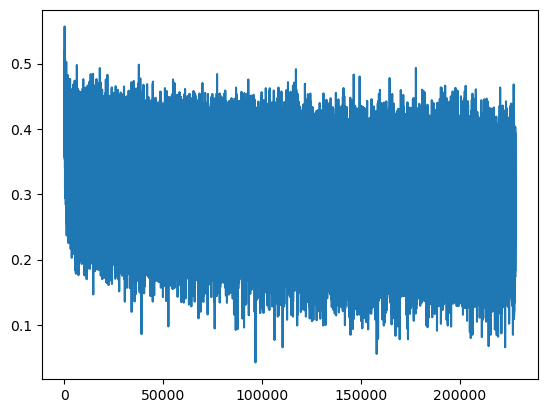

In [13]:
plt.plot(lossi)

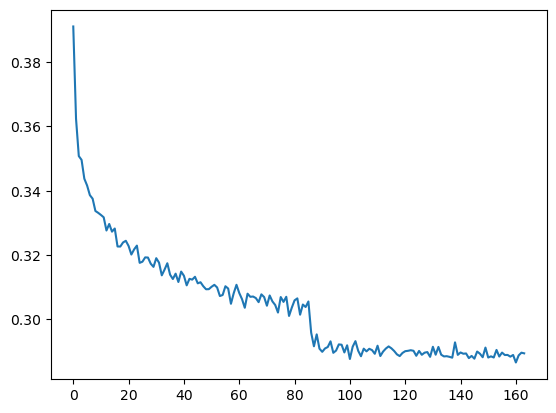

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1390).mean(1))

In [15]:
print(pytorchified.evaluate(train_words))
print(pytorchified.evaluate(dev_words))
print(pytorchified.evaluate(test_words))

1.918506145477295
2.0193910598754883
2.008430242538452


In [16]:
for _ in range(20):
    print(pytorchified.forward())

luddyn
auquancarlo
kenmi
avetsa
yusaro
izabelle
ashtie
donnedy
seevon
davyanni
ihmika
raquard
zailani
shamari
oureeson
rayge
keeda
uge
safieyla
kalaunie


In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0, 16, 18, 21,  4,  5, 14,  3],
        [ 0,  8, 15, 19,  1, 14, 14,  1],
        [ 0,  0, 25,  5,  3,  8,  9,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
# Embedding layer
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [ ]:
# Flatten layer
model.layers[1].out.shape

torch.Size([4, 80])

In [ ]:
# Linear layer
model.layers[2].out.shape

torch.Size([4, 200])

In [ ]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])